# Read FreeSolv data

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [161]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype=torch.float64

In [3]:
df = pd.read_csv("freesolv_NN_rep3dim.csv")

In [4]:
df

,x1,x2,x3,cal,expt
0,0.355909,0.654990,0.760502,9.625,11.01
1,0.188700,0.781979,0.410327,6.219,4.87
2,0.136415,0.281362,0.311954,-2.452,-1.83
3,0.166449,0.426157,0.586308,5.809,5.45
4,0.184554,0.270052,0.368473,2.917,4.21
...,...,...,...,...,...
637,0.281174,0.263573,0.442100,3.035,2.04
638,0.074772,0.481870,0.573542,4.278,5.48
639,0.251953,0.554530,0.741771,10.050,8.83
640,0.227589,0.085155,0.368976,-1.467,-0.29


# Useful functions

In [5]:
import numpy
import torch
import gpytorch
from torch import Tensor

from botorch.models import FixedNoiseGP
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [6]:
def fit_gp_model(X, Y, Yvar=None):
    if X.ndim == 1:
        X = X.unsqueeze(dim=-1)
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = FixedNoiseGP(X, Y, torch.ones(Y.shape) * 1e-4, outcome_transform=Standardize(m=Y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [7]:
from torch.autograd import (Function, grad)
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.acquisition.analytic import (_scaled_improvement, _ei_helper)
from botorch.acquisition.objective import PosteriorTransform
from typing import Dict, Optional, Tuple, Union
from botorch.utils.transforms import t_batch_mode_transform
from botorch.utils.probability.utils import (
    ndtr as Phi,
    phi,
)

In [8]:
class GittinsIndexFunction(Function):
    @staticmethod
    def forward(X: torch.Tensor, mean: torch.Tensor, sigma: torch.Tensor, cost: float, maximize: bool, bounds: torch.Tensor, eps: float):
        
        def cost_adjusted_expected_improvement(best_f):
            u = _scaled_improvement(mean, sigma, best_f, maximize)
            return sigma * _ei_helper(u) - cost

        size = X.size()[0]
        l = bounds[0]*torch.ones(size)
        h = bounds[1]*torch.ones(size)
        m = (h + l) / 2

        if maximize:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) < 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) > 0):
                h = 2 * h
        else:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) > 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) < 0):
                h = 2 * h

        # Bisection method
#         while torch.max(torch.abs(cost_adjusted_expected_improvement(best_f=m))) >= eps:
        for _ in range(100):
            sgn_m = torch.sign(cost_adjusted_expected_improvement(best_f=m))
            if maximize:
                l = torch.where(sgn_m >= 0, m, l)
                h = torch.where(sgn_m <= 0, m, h)
            else:
                l = torch.where(sgn_m <= 0, m, l)
                h = torch.where(sgn_m >= 0, m, h)
            m = (h + l) / 2
            
        return m
    
    @staticmethod
    def setup_context(ctx, inputs, output):
        X, mean, sigma, cost, maximize, bounds, eps = inputs
        
        # Save u for backward computation
        u = _scaled_improvement(mean, sigma, output, maximize)
        
        # Save values needed in the backward pass
        ctx.save_for_backward(X, mean, sigma, u)
        
        # Save boolean flag directly in ctx
        ctx.maximize = maximize  

    @staticmethod
    def backward(ctx, grad_output):
                
        # Retrieve saved tensors
        X, mean, sigma, u = ctx.saved_tensors
        maximize = ctx.maximize  # Retrieve the boolean flag directly from ctx
                
        # Gradient of mean function with respect to x
        dmean_dX = grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), retain_graph=True, allow_unused=True)[0].clone()

        # Gradient of the std function with respect to x
        dsigma_dX = grad(outputs=sigma, inputs=X, grad_outputs=torch.ones_like(sigma), retain_graph=True, allow_unused=True)[0].clone()
        
        # Check if gradients are None and handle accordingly
        if dmean_dX is None or dsigma_dX is None:
            raise RuntimeError("Gradients could not be computed for one or more components.")
        
        # Compute the gradient of the Gittins acquisition function
        if maximize:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX + phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))
        else:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX - phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))

        return grad_X, None, None, None, None, None, None

In [9]:
class GittinsIndex(AnalyticAcquisitionFunction):
    r"""Single-outcome Gittins Index (analytic).

    Computes Gittins index using the analytic formula for a Normal posterior distribution. Unlike the
    MC-based acquisition functions, this relies on the posterior at single test
    point being Gaussian (and require the posterior to implement `mean` and
    `variance` properties). Only supports the case of `q=1`. The model must be
    single-outcome.

    `GI(x) = argmin_g |E(max(f(x) - g, 0))-cost|,`

    where the expectation is taken over the value of stochastic function `f` at `x`.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> GI = GittinsIndex(model, cost=0.05)
        >>> gi = GI(test_X)
        
    """

    def __init__(
        self,
        model: Model,
        cost: float,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        bounds: torch.Tensor = torch.tensor([[-1.0], [1.0]], dtype=torch.float64),
        eps: float = 1e-6
    ):
        r"""Single-outcome Gittins Index (analytic).
        
        Args:
            model: A fitted single-outcome model.
            cost: Either a scalar or a `b`-dim Tensor (batch mode) representing
                the cost function.
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
            bounds: A `2 x d` tensor of lower and upper bounds for each column of `X`.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.cost = cost
        self.maximize = maximize
        self.bounds = bounds
        self.eps = eps
      
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate Gittins Index on the candidate set X using bisection method.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.
                Gittins Index is computed for each point individually,
                i.e., what is considered are the marginal posteriors, not the joint.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Gittins Index values at the
            given design points `X`.
        """
        
        mean, sigma = self._mean_and_sigma(X)
#         mean = self.model.posterior(X).mean.squeeze(-2).squeeze(-1)
#         sigma = self.model.posterior(X).variance.sqrt().squeeze(-2).squeeze(-1)
            
        return GittinsIndexFunction.apply(X, mean, sigma, self.cost, self.maximize, self.bounds, self.eps)

## Test 3D BayesOPT (x=df[["x1", "x2", "x3"]], y=df["energy"])

In [10]:
data_x_3D = torch.tensor(df[["x1", "x2", "x3"]].values, dtype=torch.float64)
data_x_3D

tensor([[0.3559, 0.6550, 0.7605],
        [0.1887, 0.7820, 0.4103],
        [0.1364, 0.2814, 0.3120],
        ...,
        [0.2520, 0.5545, 0.7418],
        [0.2276, 0.0852, 0.3690],
        [0.1053, 0.5603, 0.4798]], dtype=torch.float64)

In [11]:
data_y = torch.tensor(df["expt"], dtype=torch.float64)
data_y

tensor([ 1.1010e+01,  4.8700e+00, -1.8300e+00,  5.4500e+00,  4.2100e+00,
         6.2700e+00, -2.3400e+00,  3.9200e+00, -1.5800e+00,  4.6200e+00,
         1.9600e+00,  3.8800e+00,  4.3300e+00,  2.4900e+00,  2.5500e+00,
         4.7800e+00,  1.4600e+00,  2.2200e+00,  5.8500e+00, -2.8800e+00,
         6.3400e+00,  6.1000e+00,  5.4800e+00,  4.1000e+00,  4.1000e+00,
         3.5200e+00,  4.4700e+00,  2.7400e+00,  3.4300e+00,  7.8100e+00,
         8.0000e-01, -9.3000e-01,  6.7800e+00,  9.2900e+00,  4.0700e+00,
         5.9100e+00,  2.1300e+00,  3.6400e+00,  2.6800e+00, -3.1300e+00,
         1.0000e+01, -2.0600e+00,  8.1100e+00,  1.1200e+00,  2.3620e+01,
         2.8300e+00,  4.6800e+00,  5.5600e+00,  3.6500e+00,  5.4900e+00,
        -3.1200e+00,  4.4200e+00,  6.2000e+00,  6.9600e+00,  1.6000e-01,
         2.5000e-01,  9.3000e+00,  4.6300e+00,  1.0220e+01,  3.5600e+00,
         3.6500e+00,  4.2900e+00, -1.0700e+00,  9.5100e+00,  2.3000e-01,
         1.1000e-01,  1.6430e+01, -5.6000e-01,  3.2

In [13]:
# Fit the GP model using the data
objective_3D = fit_gp_model(data_x_3D, data_y, Yvar=None)

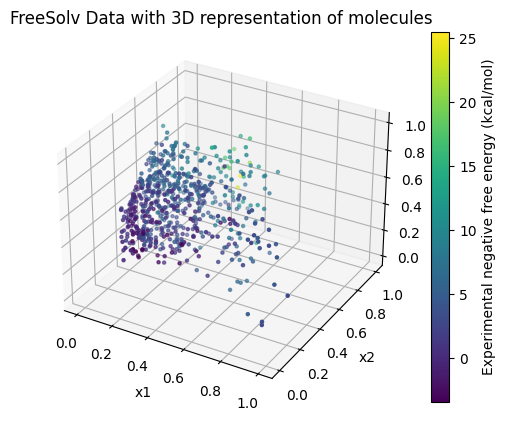

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a 3D scatter plot with color representing objective_y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing objective_y
scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=data_y.numpy(), cmap=cm.viridis, marker='.')

# Set axis labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

# Set colorbar
cbar = fig.colorbar(scatter)
cbar.set_label('Experimental negative free energy (kcal/mol)')

# Set plot title
ax.set_title('FreeSolv Data with 3D representation of molecules')

# Show the plot
plt.show()

In [151]:
import numpy as np

# Define the 3D grid over which you want to evaluate the GP model
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_grid = torch.tensor(np.vstack([X1.ravel(), X2.ravel(), X3.ravel()]).T, dtype=torch.float)

# Fit the GP model using the data
objective_3D = fit_gp_model(data_x_3D, data_y, Yvar=None)

# Evaluate the GP model at the grid points
objective_3D.eval()  # Make sure the model is in evaluation mode
with torch.no_grad():
    posterior = objective_3D.posterior(X_grid)

In [152]:
X_grid

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0204],
        [0.0000, 0.0000, 0.0408],
        ...,
        [1.0000, 1.0000, 0.9592],
        [1.0000, 1.0000, 0.9796],
        [1.0000, 1.0000, 1.0000]])

/var/folders/7t/vmwdn0kn1cl6zhvm7j0pdljh0000gn/T/ipykernel_39457/1014700473.py:13: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  data_scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(),


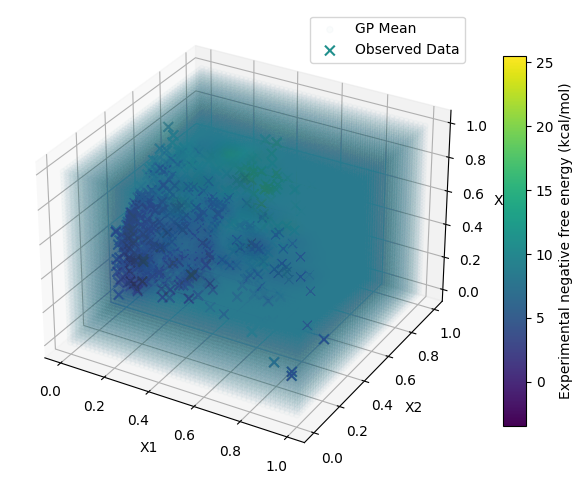

In [42]:
# Assuming observed_X and observed_Y are your observed data points and their corresponding outputs
# They should be tensors or arrays of shape [num_points, 3] and [num_points, 1], respectively

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the mean predictions as a color-coded scatter plot
mean_scatter = ax.scatter(X1.flatten(), X2.flatten(), X3.flatten(), c=posterior.mean.numpy(), cmap="viridis", alpha=0.02, label='GP Mean')

# Plot the observed data points
# Note: You may need to adjust the indexing and reshaping depending on your data structure
data_scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(),
                          c=data_y.numpy(), cmap="viridis", marker='x', s=50, edgecolors='w', label='Observed Data')

# Optionally, you can plot the confidence intervals as well (this may clutter the plot)

# Create a color bar for the mean predictions
cbar = fig.colorbar(data_scatter, shrink=0.8, aspect=16)
cbar.set_label('Experimental negative free energy (kcal/mol)')

# Set axis labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

# Legend
ax.legend()

plt.show()

In [152]:
objective_3D_mean = objective_3D.posterior(X_grid).mean
objective_3D_mean

tensor([[4.6237],
        [4.6237],
        [4.6237],
        ...,
        [4.6237],
        [4.6237],
        [4.6237]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

In [153]:
objective_3D_std = objective_3D.posterior(X_grid).variance.sqrt()
objective_3D_std

tensor([[3.9179],
        [3.9179],
        [3.9179],
        ...,
        [3.9179],
        [3.9179],
        [3.9179]], dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [154]:
objective_3D_mean.max()

tensor(23.3125, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [155]:
objective_3D_mean.min()

tensor(-8.3628, dtype=torch.float64, grad_fn=<MinBackward1>)

In [156]:
objective_3D_std.max()

tensor(3.9179, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [157]:
objective_3D_std.min()

tensor(0.1295, dtype=torch.float64, grad_fn=<MinBackward1>)

In [101]:
def plot_data(data_x_3D,data_y,observed_x,observed_y,new_point,new_value):

    # Scatter a 3D plot with color representing objective_y and observed_y
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=data_y.numpy(), cmap=cm.viridis, marker='.')

    # Add the observed points with marker 'x'
    ax.scatter(observed_x[:, 0].detach().numpy(), observed_x[:, 1].detach().numpy(), observed_x[:, 2].detach().numpy(), c=observed_y.detach().numpy(), cmap=cm.viridis, marker='x', s=50)
    
    # Add the new point with marker '*'
    ax.scatter(new_point[0, 0].numpy(), new_point[0, 1].numpy(), new_point[0, 2].numpy(), c=new_value.detach().numpy(), cmap=cm.viridis, marker='*', s=50)
    
    # Set axis labels
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # Set colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Experimental negative free energy (kcal/mol)')

In [102]:
def plot_acq(acq,data_x_3D,new_point,new_point_acq):

    # Scatter a 3D plot with color representing acq
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data_x_3D[:, 0].numpy(), data_x_3D[:, 1].numpy(), data_x_3D[:, 2].numpy(), c=acq.detach().numpy(), cmap=cm.viridis, marker='.')

    # Add the new point with marker '*'
    ax.scatter(new_point[0, 0].numpy(), new_point[0, 1].numpy(), new_point[0, 2].numpy(), c=new_point_acq.detach().numpy(), marker='*', s=50)
    
    # Set axis labels
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # Set colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Acquisition function')
    plt.show()

In [230]:
seed = 123

torch.manual_seed(seed)

x = torch.rand(8, 3, device=device, dtype=dtype).requires_grad_(True)
y = objective_3D.posterior(x).mean  # add output dimension

In [231]:
x

tensor([[0.3689, 0.0134, 0.5918],
        [0.0926, 0.4725, 0.5220],
        [0.6051, 0.5313, 0.9485],
        [0.0567, 0.8286, 0.0938],
        [0.1960, 0.2203, 0.1946],
        [0.4146, 0.7431, 0.3252],
        [0.6172, 0.1829, 0.2532],
        [0.6363, 0.6845, 0.3762]], dtype=torch.float64, requires_grad=True)

In [232]:
y

tensor([[4.3788],
        [3.6989],
        [4.7204],
        [4.6191],
        [1.7501],
        [3.7888],
        [4.6106],
        [4.9648]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

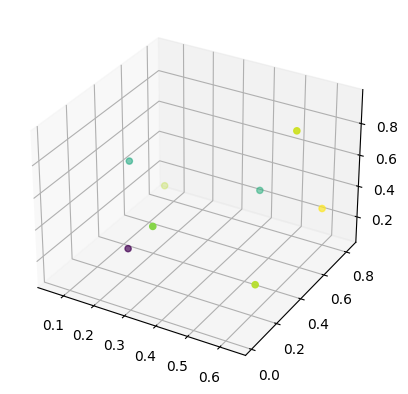

In [233]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), x[:,2].detach().numpy(), c=y.detach().numpy())

In [234]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

seed = 123

maximize = True 

num_iterations = 60

torch.manual_seed(seed)

x = torch.rand(8, 3, device=device, dtype=dtype).requires_grad_(True)
y = objective_3D.posterior(x).mean  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best values over iterations
    
EI_acq = [] # This will store the EI acq values over iterations

for i in range(num_iterations):
    
    # Fit the model
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
        q=1,
        num_restarts=30,
        raw_samples=1024,
        options={},
    )
    
    new_value = objective_3D.posterior(new_point).mean
    
    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_EI.item())
    
#     acq = BoTorch_EI.forward(data_x_3D.unsqueeze(1))
#     plot_data(data_x_3D,data_y,x,y,new_point,new_value)
#     plot_acq(acq,data_x_3D,new_point,new_point_EI)
    
    #cross_validation(x,y,nu=0.5)
    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value))
    EI_acq.append(new_point_EI.item())
    
    # Update the best observed value
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print()

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.7713225  0.48222798 0.50532836]]
new value: 4.600744095278558
new acq: 0.35241942596991405

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.77298725 0.77007365 0.18928319]]
new value: 4.624941580414691
new acq: 0.2343222693340754

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.6910978  0.86335045 0.6132733 ]]
new value: 4.840581978439497
new acq: 0.20912310817225144

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.5801775  0.02176805 0.7939442 ]]
new value: 4.623511763993525
new acq: 0.19137490462376444

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.         1.         0.38065615]]
new value: 4.624773095511847
new acq: 0.14656685722426216

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.6118704  0.5314794  0.59463084]]
new value: 5.4891782419425965
new acq: 0.13334646636193487

Iteration: 6
best oberved value: 5.4891782419425965


Iteration: 52
best oberved value: 16.410604978996687
new point: [[0.39015964 0.84719163 0.58611894]]
new value: 16.98863553392643
new acq: 0.0416071658827338

Iteration: 53
best oberved value: 16.98863553392643
new point: [[0.3896611  0.8584953  0.59081423]]
new value: 17.615317845833744
new acq: 0.23794008087055452

Iteration: 54
best oberved value: 17.615317845833744
new point: [[0.38811025 0.869708   0.5929991 ]]
new value: 17.56262163078726
new acq: 0.14496796096181244

Iteration: 55
best oberved value: 17.615317845833744
new point: [[0.39356115 0.86266834 0.59741926]]
new value: 17.947070192687075
new acq: 0.11144844884555705

Iteration: 56
best oberved value: 17.947070192687075
new point: [[0.3861522 0.8618673 0.6031011]]
new value: 16.22489904142432
new acq: 0.07212667113175153

Iteration: 57
best oberved value: 17.947070192687075
new point: [[0.35323995 0.8069875  0.56186235]]
new value: 16.51011877676162
new acq: 0.0007106267890190482

Iteration: 58
best oberved value: 17.9470

Text(0.5, 1.0, 'Performance of EI policy')

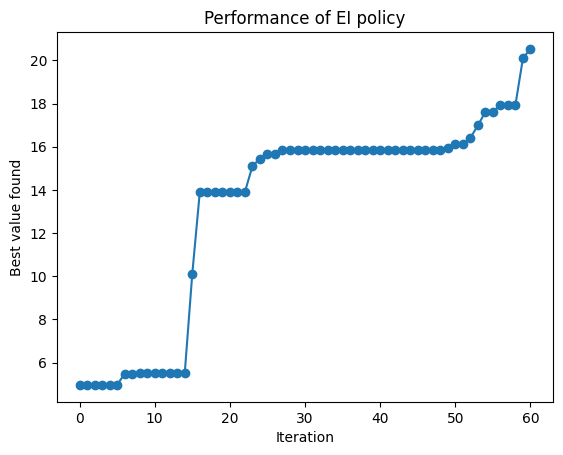

In [235]:
plt.plot(EI_best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy")

In [236]:
GI_best_dict = {}  # This dict will store the best-value arrays for different cost parameters
GI_acq_dict = {}  # This dict will store the acq arrays for different cost parameters

In [237]:
def test_Gittins(seed, maximize, cost, num_iterations, GI_best_dict, GI_acq_dict):
    
    torch.manual_seed(seed)
    
    x = torch.rand(8, 3, device=device, dtype=dtype).requires_grad_(True)
    y = objective_3D.posterior(x).mean  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    GI_best = [best_f]  # This will store the best values over iterations
    GI_acq = []  # This will store the Gittins index of the new observation over iterations

    for i in range(num_iterations):
        
        # Fit the model
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Find the optimal Gittins index value of the initial observations
        GI = GittinsIndex(model=model, cost=cost, maximize=maximize)

        if maximize:
            new_point, new_point_GI = optimize_acqf(
                acq_function=GI,
                bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
                q=1,
                num_restarts=30,
                raw_samples=1024,
                options={},
            )
        else:
            neg_GI = lambda X: -GI(X)
            new_point, new_point_neg_GI = optimize_acqf(
                acq_function=neg_GI,
                bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
                q=1,
                num_restarts=30,
                raw_samples=1024,
                options={},
            )
            new_point_GI = -new_point_neg_GI

        new_value = objective_3D.posterior(new_point).mean

        print("Iteration:", i)
        print("best oberved value:", best_f)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())
        print("new acq:", new_point_GI.item())
        

        #cross_validation(x,y,nu=0.5)


        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value))
        GI_acq.append(new_point_GI.item())

        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        GI_best.append(best_f)
        print()
        
    GI_best_dict[cost] = GI_best
    GI_acq_dict[cost] = GI_acq

In [242]:
cost=0.1
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.8289724  0.44373232 0.5302038 ]]
new value: 4.58580468234178
new acq: 5.759365185504247

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.8124165  0.69686335 0.12167018]]
new value: 4.624101925951363
new acq: 5.4669006778633555

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.7453998  0.908165   0.61444855]]
new value: 4.64642707404276
new acq: 5.384501121897497

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.6159592 0.0385791 0.7808152]]
new value: 4.623537060863991
new acq: 5.29728130862685

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.62189734 0.4603282  0.58697474]]
new value: 4.913943123698191
new acq: 5.171111947467153

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.        1.        0.4713824]]
new value: 4.624561316696495
new acq: 5.132178507256636

Iteration: 6
best oberved value: 4.964805397142094
new point: [[0.704305

Iteration: 52
best oberved value: 10.803988817708579
new point: [[0.5908479  0.65212506 0.48356923]]
new value: 10.803527549019362
new acq: 10.703525883126638

Iteration: 53
best oberved value: 10.803988817708579
new point: [[0.59084845 0.6521239  0.48356858]]
new value: 10.803524207751623
new acq: 10.703526054011046

Iteration: 54
best oberved value: 10.803988817708579
new point: [[0.5908488  0.6521235  0.48356822]]
new value: 10.80352270213223
new acq: 10.703525975181986

Iteration: 55
best oberved value: 10.803988817708579
new point: [[0.59084857 0.65212363 0.48356804]]
new value: 10.80352442255296
new acq: 10.703525792642143

Iteration: 56
best oberved value: 10.803988817708579
new point: [[0.5908488  0.65212345 0.48356858]]
new value: 10.803521536422952
new acq: 10.703525691864588

Iteration: 57
best oberved value: 10.803988817708579
new point: [[0.59083796 0.6521252  0.48357055]]
new value: 10.803560953815891
new acq: 10.703525238351602

Iteration: 58
best oberved value: 10.80398

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.1)')

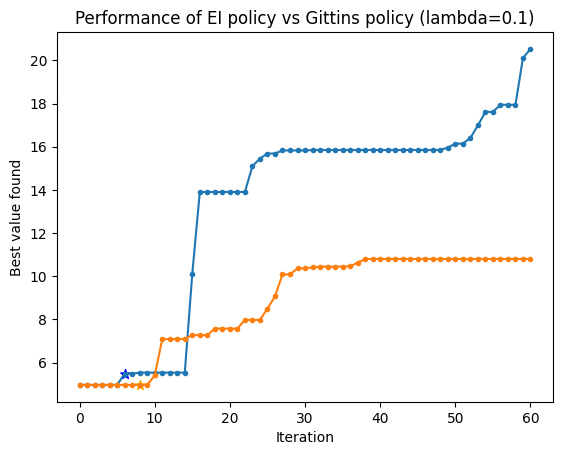

In [243]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [244]:
cost=0.05
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.85578614 0.43630302 0.53389835]]
new value: 4.590382967472859
new acq: 6.126900153651389

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.7719466 0.970281  0.6191007]]
new value: 4.626578901958968
new acq: 5.827747003860075

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.82327384 0.70740527 0.10239549]]
new value: 4.623892019522858
new acq: 5.719016021820343

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.6400181  0.         0.78776205]]
new value: 4.6236415382614435
new acq: 5.618712180938104

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.388625   0.12919743 1.        ]]
new value: 4.623755626635562
new acq: 5.447463391675242

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.6341878  0.42247373 0.5864724 ]]
new value: 4.876147806414071
new acq: 5.387691396516409

Iteration: 6
best oberved value: 4.964805397142094
new point: [[0.

Iteration: 53
best oberved value: 12.739306904149462
new point: [[0.54183453 0.72691417 0.12849382]]
new value: 12.739271385402574
new acq: 12.689183771650821

Iteration: 54
best oberved value: 12.739306904149462
new point: [[0.5418339  0.7269142  0.12849411]]
new value: 12.739271422127555
new acq: 12.689188248021896

Iteration: 55
best oberved value: 12.739306904149462
new point: [[0.5418337 0.726914  0.1284942]]
new value: 12.739271505869791
new acq: 12.68919229197975

Iteration: 56
best oberved value: 12.739306904149462
new point: [[0.54183346 0.7269144  0.128495  ]]
new value: 12.739268654913964
new acq: 12.68919596262145

Iteration: 57
best oberved value: 12.739306904149462
new point: [[0.5418342  0.7269146  0.12849455]]
new value: 12.739269001862795
new acq: 12.689199201554459

Iteration: 58
best oberved value: 12.739306904149462
new point: [[0.5418336  0.7269144  0.12849468]]
new value: 12.7392696700844
new acq: 12.689202167403106

Iteration: 59
best oberved value: 12.7393069041

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.05)')

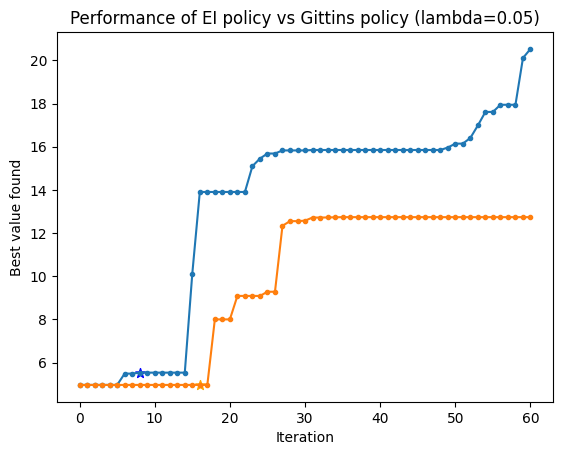

In [245]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [246]:
cost=0.01
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.9030051  0.42900127 0.5365604 ]]
new value: 4.604376362212175
new acq: 6.862760366953285

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.805418  1.        0.6482819]]
new value: 4.623913802936755
new acq: 6.548855059031759

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.8608997  0.7286837  0.06247765]]
new value: 4.623691280211919
new acq: 6.402137468430318

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.67957586 0.         0.7964709 ]]
new value: 4.623651507529674
new acq: 6.263477566562566

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.9480986  0.         0.01571406]]
new value: 4.6187569340805075
new acq: 6.082994571018089

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.3720045 0.        1.       ]]
new value: 4.623659718977706
new acq: 5.992067310586043

Iteration: 6
best oberved value: 4.964805397142094
new point: [[0. 1.

Iteration: 53
best oberved value: 14.237005932480177
new point: [[0.44098097 0.46761426 0.9676683 ]]
new value: 14.23700882599205
new acq: 14.226698174717981

Iteration: 54
best oberved value: 14.23700882599205
new point: [[0.4409817  0.46761343 0.9676689 ]]
new value: 14.2370102528707
new acq: 14.226720479357915

Iteration: 55
best oberved value: 14.2370102528707
new point: [[0.44098192 0.46761227 0.96766824]]
new value: 14.237012534014308
new acq: 14.226739933603625

Iteration: 56
best oberved value: 14.237012534014308
new point: [[0.4409833 0.4676121 0.9676693]]
new value: 14.237013737507162
new acq: 14.226757114004194

Iteration: 57
best oberved value: 14.237013737507162
new point: [[0.44098392 0.4676115  0.96766925]]
new value: 14.237015383468517
new acq: 14.22677234561472

Iteration: 58
best oberved value: 14.237015383468517
new point: [[0.44098455 0.4676109  0.9676694 ]]
new value: 14.237016788375659
new acq: 14.226785976317824

Iteration: 59
best oberved value: 14.2370167883756

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.01)')

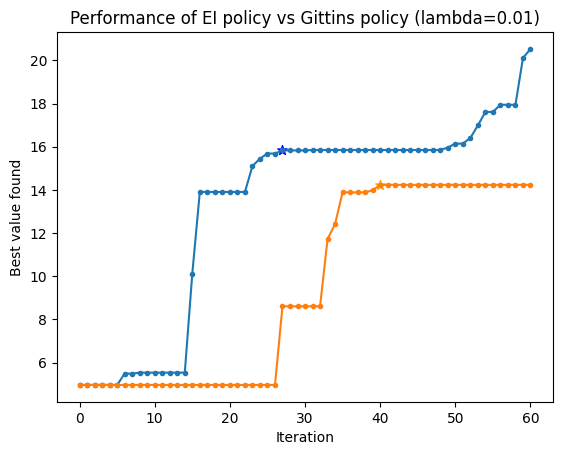

In [247]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [239]:
cost=0.005
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.9185988  0.42758316 0.5368309 ]]
new value: 4.608828351081842
new acq: 7.142758713314368

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.8799954  0.70756614 0.03073117]]
new value: 4.623676812302383
new acq: 6.821461880126515

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.81927764 1.         0.63694245]]
new value: 4.62385959094446
new acq: 6.666125584444774

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.6924791  0.         0.80085003]]
new value: 4.623654281688707
new acq: 6.506054557975435

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.9623722  0.         0.00593849]]
new value: 4.621107254772847
new acq: 6.327394949971696

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.36958686 0.         1.        ]]
new value: 4.623659654853962
new acq: 6.2104561127768925

Iteration: 6
best oberved value: 4.964805397142094
new point: [[

Iteration: 53
best oberved value: 14.236841886634757
new point: [[0.44093162 0.4676873  0.9676407 ]]
new value: 14.236843105629344
new acq: 14.231815568055357

Iteration: 54
best oberved value: 14.236843105629344
new point: [[0.4409338  0.4676874  0.96764445]]
new value: 14.236845081823098
new acq: 14.23179387635889

Iteration: 55
best oberved value: 14.236845081823098
new point: [[0.44093567 0.4676867  0.9676465 ]]
new value: 14.236848553875852
new acq: 14.231780959602919

Iteration: 56
best oberved value: 14.236848553875852
new point: [[0.4409352  0.46768782 0.96764994]]
new value: 14.236843624638677
new acq: 14.231773717811308

Iteration: 57
best oberved value: 14.236848553875852
new point: [[0.44093567 0.4676884  0.9676519 ]]
new value: 14.236842147475542
new acq: 14.231769309791453

Iteration: 58
best oberved value: 14.236848553875852
new point: [[0.4409362  0.46768755 0.96765244]]
new value: 14.236844219803984
new acq: 14.231766955972528

Iteration: 59
best oberved value: 14.2368

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.005)')

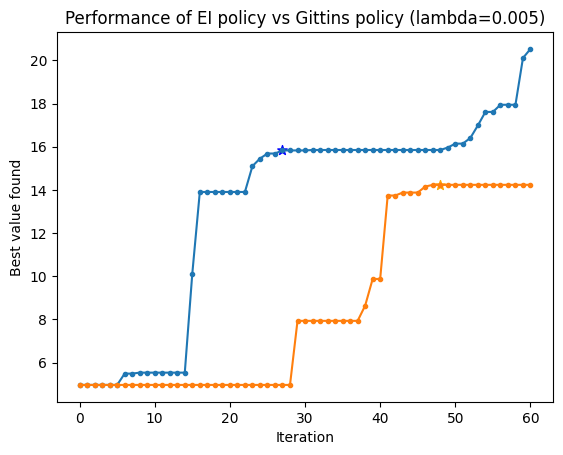

In [240]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c='orange', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

In [248]:
cost=0.001
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict, GI_acq_dict=GI_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.9477969  0.42570525 0.5368469 ]]
new value: 4.615525964935435
new acq: 7.731873747537977

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.89910686 0.7191856  0.00273157]]
new value: 4.623668127140524
new acq: 7.3920799079508654

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.83998615 1.         0.66064376]]
new value: 4.623716338026698
new acq: 7.201066642224658

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.71712446 0.         0.81071216]]
new value: 4.623658749893762
new acq: 7.01091645056508

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.9875494 0.        0.       ]]
new value: 4.622297719546407
new acq: 6.8295732643911435

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0. 1. 1.]]
new value: 4.6236655476305755
new acq: 6.689098648721842

Iteration: 6
best oberved value: 4.964805397142094
new point: [[0.39584047 1.         1. 

Iteration: 53
best oberved value: 14.237182676223412
new point: [[0.441194   0.46748373 0.96766603]]
new value: 14.237234775429854
new acq: 14.238122199004973

Iteration: 54
best oberved value: 14.237234775429854
new point: [[0.4411801  0.46747637 0.96763575]]
new value: 14.237250682325847
new acq: 14.237910893934487

Iteration: 55
best oberved value: 14.237250682325847
new point: [[0.44117424 0.46746728 0.96761554]]
new value: 14.23724956201071
new acq: 14.237745151308726

Iteration: 56
best oberved value: 14.237250682325847
new point: [[0.44117564 0.46745893 0.9676048 ]]
new value: 14.237244638853369
new acq: 14.237609378701194

Iteration: 57
best oberved value: 14.237250682325847
new point: [[0.44117725 0.46745184 0.9675971 ]]
new value: 14.23723897750671
new acq: 14.237495316582333

Iteration: 58
best oberved value: 14.237250682325847
new point: [[0.44117394 0.4674548  0.96759063]]
new value: 14.237235147832195
new acq: 14.237397704911569

Iteration: 59
best oberved value: 14.23725

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.001)')

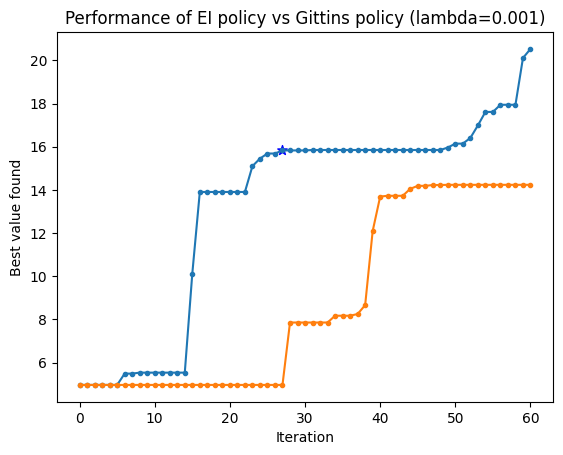

In [249]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={})".format(cost))

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy on FreeSolv Data')

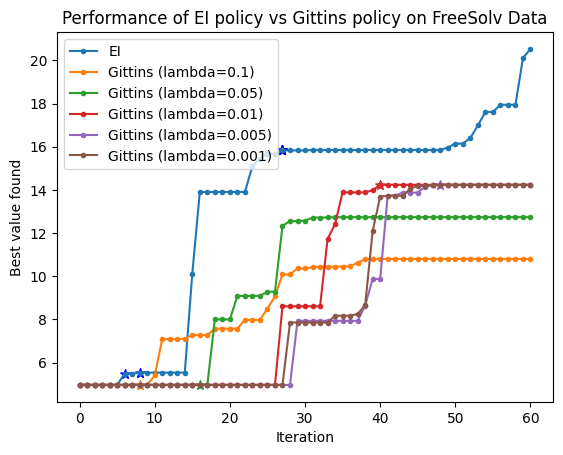

In [250]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
    plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
    line = plt.plot(GI_best_dict[cost], '.-', label="Gittins (lambda={})".format(cost))
    if np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0].size > 0:
        GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
        plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c=line[0].get_color(), marker='*', s=50)

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy on FreeSolv Data")

In [251]:
UCB_best_dict = {}  # This dict will store the best-value arrays for different cost parameters
UCB_acq_dict = {}  # This dict will store the acq arrays for different cost parameters

In [252]:
from botorch.acquisition import UpperConfidenceBound

def test_UCB(seed, maximize, beta, num_iterations, UCB_best_dict, UCB_acq_dict):

    torch.manual_seed(seed)

    x = torch.rand(8, 3, device=device, dtype=dtype).requires_grad_(True)
    y = objective_3D.posterior(x).mean  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    UCB_best = [best_f] # This will store the best values over iterations

    UCB_acq = [] # This will store the UCB acq values over iterations

    for i in range(num_iterations):

        # Fit the model
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Optimize UCB
        BoTorch_UCB = UpperConfidenceBound(model=model, beta=beta, maximize=maximize)

        new_point, new_point_UCB = optimize_acqf(
            acq_function=BoTorch_UCB,
            bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
            q=1,
            num_restarts=30,
            raw_samples=1024,
            options={},
        )

        new_value = objective_3D.posterior(new_point).mean

        print("Iteration:", i)
        print("best oberved value:", best_f)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())
        print("new acq:", new_point_UCB.item())
        print()

        #cross_validation(x,y,nu=0.5)

        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value))
        UCB_acq.append(new_point_UCB.item())

        # Update the best observed value
        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        UCB_best.append(best_f)
        
    UCB_best_dict[beta] = UCB_best
    UCB_acq_dict[beta] = UCB_acq

In [253]:
beta=2.72
maximize=True
test_UCB(seed=seed, maximize=maximize, beta=beta, num_iterations=num_iterations, UCB_best_dict=UCB_best_dict, UCB_acq_dict=UCB_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.8461163  0.4386024  0.53282106]]
new value: 4.588190850912018
new acq: 6.514742344471008

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.7657668  0.96283776 0.6152824 ]]
new value: 4.628176822337268
new acq: 6.217097754044119

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.817788   0.70787084 0.10468606]]
new value: 4.623960352054396
new acq: 6.112683859742457

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.6340315  0.         0.79281086]]
new value: 4.623642383812671
new acq: 6.015530858460242

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.38609135 0.14102103 1.        ]]
new value: 4.6239183525403185
new acq: 5.845613969120939

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.         1.         0.48380205]]
new value: 4.62458344041098
new acq: 5.777155575926672

Iteration: 6
best oberved value: 4.964805397142094
new point: [[

Iteration: 53
best oberved value: 20.55244986800454
new point: [[0.41577214 0.8726064  0.5921005 ]]
new value: 20.603484998061507
new acq: 20.589870484245026

Iteration: 54
best oberved value: 20.603484998061507
new point: [[0.41688555 0.8727433  0.5922639 ]]
new value: 20.60247804788878
new acq: 20.618934121239686

Iteration: 55
best oberved value: 20.603484998061507
new point: [[0.41645718 0.87274045 0.5919825 ]]
new value: 20.60425598164707
new acq: 20.614211270903713

Iteration: 56
best oberved value: 20.60425598164707
new point: [[0.41666588 0.8722922  0.5923226 ]]
new value: 20.601656965076806
new acq: 20.61287816555688

Iteration: 57
best oberved value: 20.60425598164707
new point: [[0.41625622 0.87292445 0.59186006]]
new value: 20.60369589851499
new acq: 20.612179129315063

Iteration: 58
best oberved value: 20.60425598164707
new point: [[0.4161776 0.872354  0.591849 ]]
new value: 20.602337757874714
new acq: 20.611211112107974

Iteration: 59
best oberved value: 20.60425598164707

Text(0.5, 1.0, 'Performance of EI vs Gittins (lambda=0.005) vs UCB (beta=2.72)')

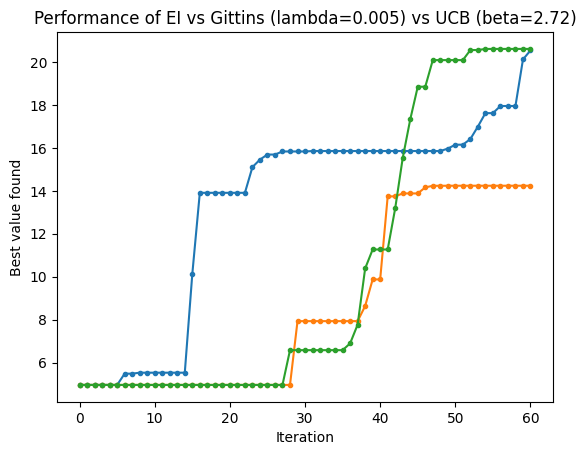

In [254]:
cost=0.005
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.plot(UCB_best_dict[beta],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins (lambda={}) vs UCB (beta={})".format(cost, beta))

In [255]:
beta=3.18
maximize=True
test_UCB(seed=seed, maximize=maximize, beta=beta, num_iterations=num_iterations, UCB_best_dict=UCB_best_dict, UCB_acq_dict=UCB_acq_dict)

Iteration: 0
best oberved value: 4.964805397142094
new point: [[0.8579141 0.4358453 0.5340893]]
new value: 4.590918444338661
new acq: 6.6570575812177735

Iteration: 1
best oberved value: 4.964805397142094
new point: [[0.7745201  0.97595835 0.6205615 ]]
new value: 4.6259629000891564
new acq: 6.3567300410596985

Iteration: 2
best oberved value: 4.964805397142094
new point: [[0.8277286  0.7116738  0.09529331]]
new value: 4.623837650260157
new acq: 6.244176316236699

Iteration: 3
best oberved value: 4.964805397142094
new point: [[0.64389646 0.         0.7945604 ]]
new value: 4.623645990060112
new acq: 6.138474239506821

Iteration: 4
best oberved value: 4.964805397142094
new point: [[0.38161725 0.12510553 1.        ]]
new value: 4.623734976879642
new acq: 5.960643708046991

Iteration: 5
best oberved value: 4.964805397142094
new point: [[0.        1.        0.5156618]]
new value: 4.624536857996651
new acq: 5.8857155600912625

Iteration: 6
best oberved value: 4.964805397142094
new point: [[0.

Iteration: 54
best oberved value: 12.080725969354642
new point: [[0.3692156  0.767018   0.59540564]]
new value: 15.480692224725281
new acq: 13.083246600161923

Iteration: 55
best oberved value: 15.480692224725281
new point: [[0.35001191 0.77393293 0.5896095 ]]
new value: 18.161712636156434
new acq: 16.792793830025833

Iteration: 56
best oberved value: 18.161712636156434
new point: [[0.32425642 0.784235   0.5826048 ]]
new value: 19.49430554160543
new acq: 19.749865111219705

Iteration: 57
best oberved value: 19.49430554160543
new point: [[0.33090103 0.78267837 0.5702138 ]]
new value: 17.875372363408072
new acq: 19.98129810379208

Iteration: 58
best oberved value: 19.49430554160543
new point: [[0.32489154 0.79832244 0.5913156 ]]
new value: 19.487753804441844
new acq: 20.219680254571916

Iteration: 59
best oberved value: 19.49430554160543
new point: [[0.31348744 0.7797324  0.5937859 ]]
new value: 18.29636229825442
new acq: 20.191751194193873



Text(0.5, 1.0, 'Performance of EI vs Gittins (lambda=0.001) vs UCB (beta=3.18)')

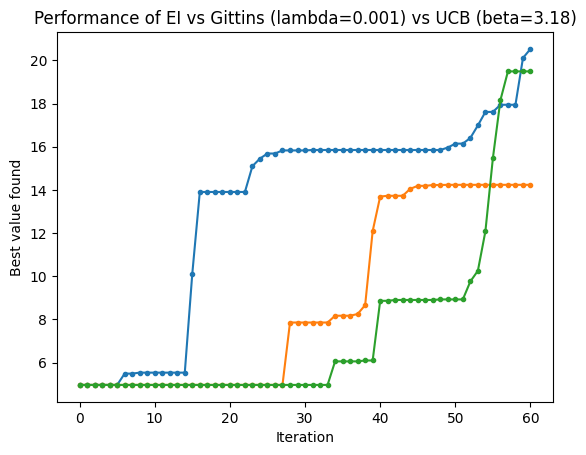

In [256]:
cost=0.001
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.plot(UCB_best_dict[beta],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins (lambda={}) vs UCB (beta={})".format(cost, beta))

Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB on FreeSolv Data')

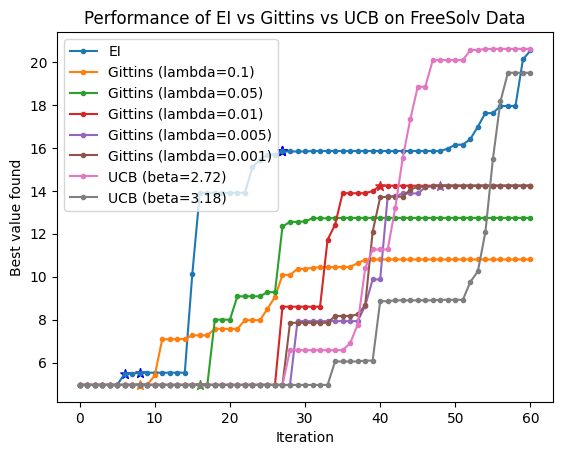

In [257]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
    plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
    line = plt.plot(GI_best_dict[cost], '.-', label="Gittins (lambda={})".format(cost))
    if np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0].size > 0:
        GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
        plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c=line[0].get_color(), marker='*', s=50)

# Plotting UCB
plt.plot(UCB_best_dict[2.72], '.-', label="UCB (beta={})".format(2.72))
plt.plot(UCB_best_dict[3.18], '.-', label="UCB (beta={})".format(3.18))
    
# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB on FreeSolv Data")

In [210]:
torch.manual_seed(seed)

lmbda = 0.1

x = torch.rand(8, 3, device=device, dtype=dtype).requires_grad_(True)
y = objective_3D.posterior(x).mean  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 

GI_best = [best_f]  # This will store the best values over iterations
stopping_time = []  # This will store the stopping times

for i in range(num_iterations):

    # Fit the model
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

    # Find the optimal Gittins index value of the initial observations
    GI = GittinsIndex(model=model, cost=lmbda, maximize=maximize)

    if maximize:
        new_point, new_point_GI = optimize_acqf(
            acq_function=GI,
            bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
            q=1,
            num_restarts=30,
            raw_samples=1024,
            options={},
        )
    else:
        neg_GI = lambda X: -GI(X)
        new_point, new_point_neg_GI = optimize_acqf(
            acq_function=neg_GI,
            bounds=torch.tensor([[0., 0., 0.],[1., 1., 1.]]),
            q=1,
            num_restarts=30,
            raw_samples=1024,
            options={},
        )
        new_point_GI = -new_point_neg_GI

    new_value = objective_3D.posterior(new_point).mean

    print("Iteration:", i)
    print("best oberved value:", best_f)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    print("new acq:", new_point_GI.item())


    #cross_validation(x,y,nu=0.5)


    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value))

    if maximize:
        if new_point_GI.item() < best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = max(best_f, new_value.item())
    else:
        if new_point_GI.item() > best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = min(best_f, new_value.item())

    GI_best.append(best_f)
    print()

Iteration: 0
best oberved value: 6.256994642783683
new point: [[0.2430418 0.5089446 0.       ]]
new value: 4.6154469536889335
new acq: 7.851074107902104

Iteration: 1
best oberved value: 6.256994642783683
new point: [[0.96014047 0.36275205 0.        ]]
new value: 4.623648034111007
new acq: 7.513012382896363

Iteration: 2
best oberved value: 6.256994642783683
new point: [[0.6395367  0.63016313 0.12687144]]
new value: 4.796076592094676
new acq: 7.048311687162549

Iteration: 3
best oberved value: 6.256994642783683
new point: [[0.5266288  0.21851833 0.05941985]]
new value: 4.603951604905347
new acq: 6.9710873860482625

Iteration: 4
best oberved value: 6.256994642783683
new point: [[0.6973062  0.5370996  0.02293959]]
new value: 4.923538753985053
new acq: 6.497703285699137

Iteration: 5
best oberved value: 6.256994642783683
new point: [[0.85024905 0.41186792 0.12357983]]
new value: 4.624464821473632
new acq: 6.5663030306201104

Iteration: 6
best oberved value: 6.256994642783683
new point: [[

Iteration: 52
best oberved value: 20.604759576080486
new point: [[0.41591898 0.8729217  0.59209937]]
new value: 20.604370857400248
new acq: 20.605226838588948

Iteration: 53
best oberved value: 20.604759576080486
new point: [[0.4162724  0.87283415 0.5923223 ]]
new value: 20.604570721716918
new acq: 20.605147103004654

Iteration: 54
best oberved value: 20.604759576080486
new point: [[0.41621247 0.8730476  0.5920771 ]]
new value: 20.604693406354034
new acq: 20.605109583562303

Iteration: 55
best oberved value: 20.604759576080486
new point: [[0.41591257 0.8727653  0.5922562 ]]
new value: 20.604200009330857
new acq: 20.605070718359833

Iteration: 56
best oberved value: 20.604759576080486
new point: [[0.41638598 0.8730145  0.5921524 ]]
new value: 20.604757078872066
new acq: 20.605024014449832

Iteration: 57
best oberved value: 20.604759576080486
new point: [[0.41600594 0.87294555 0.5920922 ]]
new value: 20.604601202323547
new acq: 20.604976897222002

Iteration: 58
best oberved value: 20.604

Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB on FreeSolv Data')

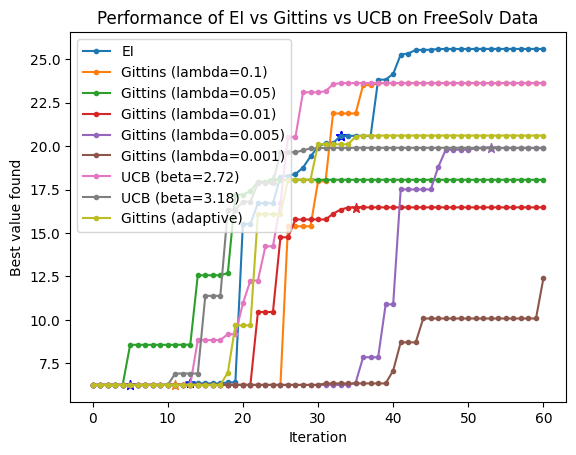

In [211]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    EI_stopping_time = np.where(np.array(EI_acq) < cost)[0][0]
    plt.scatter(EI_stopping_time, EI_best[EI_stopping_time], c='blue', marker='*', s=50)
    line = plt.plot(GI_best_dict[cost], '.-', label="Gittins (lambda={})".format(cost))
    if np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0].size > 0:
        GI_stopping_time = np.where(np.array(GI_acq_dict[cost]) < np.array(GI_best_dict[cost][:-1]))[0][0]
        plt.scatter(GI_stopping_time, GI_best_dict[cost][GI_stopping_time], c=line[0].get_color(), marker='*', s=50)

# Plotting UCB
plt.plot(UCB_best_dict[2.72], '.-', label="UCB (beta={})".format(2.72))
plt.plot(UCB_best_dict[3.18], '.-', label="UCB (beta={})".format(3.18))

plt.plot(GI_best, '.-', label='Gittins (adaptive)')

    
# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB on FreeSolv Data")

In [212]:
EI_best

[6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.256994642783683,
 6.34185982090248,
 6.34185982090248,
 6.34185982090248,
 6.34185982090248,
 6.34185982090248,
 6.402212728758001,
 6.402212728758001,
 15.519932162917293,
 15.519932162917293,
 16.712097499017325,
 16.712097499017325,
 16.712097499017325,
 18.24550751271546,
 18.30723202298644,
 18.389928850667626,
 18.762940285973958,
 19.402765310424794,
 19.963385768904995,
 20.166902280272783,
 20.166902280272783,
 20.590154649963686,
 20.590154649963686,
 20.590154649963686,
 20.590154649963686,
 20.590154649963686,
 23.823854891881123,
 23.823854891881123,
 24.15459914011049,
 25.264243442930226,
 25.32609475901008,
 25.53282686590778,
 25.53282686590778,
 25.54545539344371,
 25.58665974942008,
 25.58665974942008,
 25.58665974942008,
 25.58

In [213]:
GI_best_dict

{0.1: [6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  15.383106337797745,
  15.383106337797745,
  15.383106337797745,
  15.383106337797745,
  17.970052831852506,
  17.970052831852506,
  21.87778917536459,
  21.87778917536459,
  21.87778917536459,
  21.87778917536459,
  23.503762300857904,
  23.503762300857904,
  23.61690279399155,
  23.6217511137701,
  23.62250994261597,
  23.62265789407018,
  23.62265789407018,
  23.62265789407018,
  23.62265789407018,
  23.62265789407018,
  23.62265789407018,
 

In [214]:
GI_acq_dict

{0.1: [7.851074107902104,
  7.513012382896363,
  7.048311687162549,
  6.9710873860482625,
  6.497703285699137,
  6.5663030306201104,
  6.578574594769927,
  6.452807470616049,
  6.426668203104651,
  6.402516809286501,
  6.623859421892869,
  6.242861515462939,
  6.273693488578578,
  6.067719414960303,
  5.936518991248326,
  6.1594804199035735,
  5.772646399251819,
  6.159283214944759,
  5.7285658775123345,
  5.685393623949212,
  5.590044512481491,
  6.1550993735686355,
  5.575677713309638,
  5.535855795023897,
  5.496723293965992,
  5.479633700266444,
  16.201712408754233,
  16.026942610492398,
  15.419331505724616,
  16.582282335119082,
  18.34094993084127,
  18.790406977554902,
  22.1429808609237,
  22.337753123139578,
  22.046015248948024,
  22.38888309637705,
  23.742782410376968,
  23.493730555728554,
  23.518092031680567,
  23.520151514578437,
  23.521581220877863,
  23.52222022838729,
  23.52231690577984,
  23.522341893398576,
  23.522354077753334,
  23.522358710674332,
  23.52236

In [215]:
UCB_best_dict

{2.72: [6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  6.256994642783683,
  8.837381560540898,
  8.837381560540898,
  8.837381560540898,
  8.837381560540898,
  9.174628190941519,
  9.174628190941519,
  10.943219969244307,
  12.262981660642204,
  12.262981660642204,
  14.232496945723511,
  14.232496945723511,
  16.71280180988795,
  20.533303724279623,
  20.533303724279623,
  23.09368226166563,
  23.09368226166563,
  23.09368226166563,
  23.15394344443976,
  23.558283593251403,
  23.623620787862148,
  23.623620787862148,
  23.623620787862148,
  23.624219378969475,
  23.62435436728828,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640248,
  23.62449060640